# Deterministic annealing, a la Rose


### How to understand the algorithm (some thoughts)

Given the samples (zero temperature potential), the temperature sets the effective potential.

Now, given some (fixed number of) codevectors, where could they settle down? It seems like they can only reach the minimal of the effective potential (stable fixed points i.e. attractors). Given sufficient number of codevectors, we can access all the minima at a particular temperature. **To see this, prevent the algorithm from sprouting new codevectors, and choose a temperature such that there are multiple vacua.** The fact that perturbations around one vacuum can take the codevector to other vacua means that this algorithm is intelligent enough to have tunnelling incorporated into the flow equations!

**Think of the compression as a transfer function from the data to the code vectors. The data might grow, but we could keep the number of codevectors fixed, if we so choose**

In [1]:
using Plots
pyplot()

Plots.PyPlotBackend()

### Guts of the code

Initialize a bunch of vectors (array data structure) or start with a single vector as the root of a tree.
Label each cluster by a centroid vectors and the "size" of the cluster as $\{(v_\mu,s_\mu)\}$ and the data points as $\{x_i\}$

* For P, first index runs over all the points, second index runs over the possible codevectors. 
* For V, the first index runs over all the coordinates, second over cluster labels.

The energy cost (distortion) of assigning data point $x_i$ to cluster $v_\mu$ is $E(v_\mu | x_i)$. This notion of distortion is where programmer input is involved ("supervised" learning)

* Here we assume a geometric (distance) notion of distortion.
* The distortion measure in labelling each point has a very mild/indirect dependence on the labelling of other points. A weighting factor encourages preferential attachment to codevectors which are popular. But that only cares about the weight of each codevector, not the finer details of which points are assigned to the codevector.

It is assumed that all data samples are "independent", so the their free energies simply add up.

In [ ]:
function distortion(beta::Float64,p::Array{Float64,1}, v::Array{Float64,1})
    distortion = beta*sum((p-v).^2)
    return distortion
end

### At each temperature

Iterate through this EM/AM like optimization sufficient number of times.

1. Given code vector locations, find the soft partitioning by calculate the distances and incorporating the aggregating factor for preferential attachment.
2. For the given soft partitioning, re-center the code vectors appropriately.

#### Fix formulae below

$$p(v_\mu | x_i) = e^{-\beta E(v_\mu | x_i)} / Z_i$$ where
$$Z_x = \sum_\mu e^{-\beta E(v_\mu | x_i)}$$

In [3]:
function assignToCodevec(beta::Float64,S::Array{Float64,2},CVset::Array{Float64,2},AggregWt::Array{Float64,1})
    Wt = zeros(size(S,1),size(CVset,2))
    threshold = 0.0
    
    # wrong order of iterating (What is optimal/efficient :-?)
    # Maybe I should store S in transposed form??
    # For finding distortion we need the vector for ech point while 
    # for finding the centroid we need the X-coordinate of every point
    
    for i = 1:size(Wt,1) # i indexes points
        pt = S[i,:]
        for j in 1:size(Wt,2) # j indexes codevectors
            Wt[i,j] = exp(-distortion(beta,pt,CVset[:,j]))
            
            # Preferential attachment is VERY VERY important!
            Wt[i,j] = AggregWt[j]*Wt[i,j]
        end
        Wt[i,:] = Wt[i,:]./(sum(Wt[i,:])) # Normalizing probabilities
    end
    
    # Maintain a list of points for each codevector, 
    # and "prune" all those points which don't come within a probability threshold for a codevector?
    # This way, only points belonging to a cluster can influence the future evolution of the cluster
    # Have a tree data structure, where each leaf carries a list of points "relevant" to it
    # and individual points could be relevant to more than one cluster
    # There is the cost of "splitting" points and assigning memory
    # but each CV need not scan over the FULL set of points each time.
    
    return Wt
end

assignToCodevec (generic function with 1 method)

In [4]:
function reCenterCodevec(S::Array{Float64,2},Wt::Array{Float64,2})
    AggregWt = sum(Wt',2)[:,1] #extract column because, the sum function in Julia_v0.5 does not drop a dimension
    CVset = ((Wt'*S)./AggregWt)' #weighted average to assign new CodeVectors
    return (CVset, AggregWt)
end

reCenterCodevec (generic function with 1 method)

In [5]:
function findCVs(beta::Float64,pts::Array{Float64,2},CVin::Array{Float64,2},AggWtIn::Array{Float64,1})
    (CV, AggregWt) = (CVin, AggWtIn)
    
    for i in collect(1:20) # convergence condition
        Wts = assignToCodevec(beta, pts, CV, AggregWt);
        (CV, AggregWt) = reCenterCodevec(pts,Wts);
    end
    return (CV,AggregWt)
end

findCVs (generic function with 1 method)

In [6]:
### Old version of functions
### ------------------------

# function destabilize(beta::Float64, S::Array{Float64,2}, c::Array{Float64,1}, AWt::Float64, threshold::Float64)
#     @show perturbSize = 0.00001/beta #fluctuations whose size is set by the temperature
#     perturbDir = rand(size(c)) |> normalize
#     perturbation = perturbSize*perturbDir
#     @show (c1,c2) = (c+perturbation,c-perturbation)

#     AggregWt12 = [AWt/2,AWt/2]  
#     @show (Cnew, AggregWt12) = findCVs(beta, S, hcat(c1,c2), AggregWt12)
#     # IT IS INCORRECT TO CLUSTER AROUND ONLY TWO CVs!!! 
#     # THE PRESENCE OF OTHER CVs AFFECTS THESE!!!

#     # If the perturbation did no cause a sufficient split, then drop one CV
#     conditionInstability = (beta*norm(Cnew[:,1]-Cnew[:,2]) < threshold)
#     println(conditionInstability)
#     if(true)
#         Cnew = [Cnew[:,1:1]]
#         AggregWt12 = [AggregWt12[1]]
#     else
#        Cnew = [Cnew[:,1],Cnew[:,2]] 
#     end
#
#     # Return wither one or two vectors, depending on the result of the perturbation
#     return (Cnew, AggregWt12)
# end

# function sproutClusterMaybe(beta::Float64, S::Array{Float64,2}, CVset::Array{Float64,2}, AggregWt::Array{Float64,1}, threshold::Float64)
#     CVsetNew = []
#     AggregWtNew = []

#     for j in collect(1:1) #collect(1:size(CVset,2))
#         toDestabilize = CVset[:,j]
#         AWt = AggregWt[j]
#         (CV_splitMaybe, AWt_splitMaybe) = destabilize(beta, S, toDestabilize, AWt, threshold)
        
#         push!(CVsetNew, CV_splitMaybe...)
#         push!(AggregWtNew, AWt_splitMaybe...)
#     end
#     (CV_ret, AggregWt_ret) = (hcat(CVsetNew...), vcat(AggregWtNew...))
    
#     return (CV_ret, AggregWt_ret)
#     #after converting Array{Array{Float64,1}} to Array{Float64,1}
# end

### Sprouting new clusters

How to check for a phase transition? Perturb a vector as $\vec{v} \pm \vec{\epsilon}$ (I think ${|\vec{\epsilon}| \propto T}$ is a good idea) and see if those two perturbations fall towards different optima as you cool the system further. To prevent memory re-allocation every cooling step, we maintain two copies of each codevector and sprout new vectors iff there is an instability.

> _What about high dimensions?_ The tricky thing would be that in a $d$ dimensional space, there are $2^{d-1}$ possible choices for $\vec{\epsilon}$ (roughly scales as the number of "quadrants/corners"). So, checking for a phase transition seems very difficult when $d \gg 1$. Well, among random vectors, the set that is orthogonal to the "right" direction of split is a set of measure zero, so choosing a random vector will be fine. But I guess that the problem is that a random (normalized) vector can have a small projection along the right direction? Would the projection be linearly (polynomially) small or exponentially small? If it's too small, then we might not have the numerical precision to do many iterations.

In [7]:
function sproutClusterMaybe(beta::Float64, S::Array{Float64,2}, CVin::Array{Float64,2}, AggWtIn::Array{Float64,1}, threshold::Float64)  
    CVset = CVin
    AggregWt = AggWtIn
    
    perturbSize = 0.00001/beta #fluctuations whose size is set by the temperature
    threshold = 0.0001/beta

    for j in collect(1:2:size(CVset,2))
        # Destabilize each codevector pair and check whether the two vectors meet
        perturbDir = rand(size(CVset[:,j])) |> normalize
        perturbation = perturbSize*perturbDir

        (CVset[:,j],CVset[:,j+1]) = (CVset[:,j] + perturbation, CVset[:,j+1] - perturbation)
        (CVset, AggregWt) = findCVs(beta, S, CVset, AggregWt)
        
        conditionInstability = (beta*norm(CVset[:,j] - CVset[:,j+1]) > threshold)
        if(conditionInstability)
            # Enlarging the set of code vectors and ensuring that each has two copies in successive locations
            CVset = hcat(CVset, hcat(CVset[:,j+1],CVset[:,j+1]))
            push!(AggregWt,(AggregWt[j+1],AggregWt[j+1])...)
            CVset[:,j+1] = CVset[:,j]
            AggregWt[j+1] = AggregWt[j]
            
            #@show (size(CVset),size(AggregWt))
        end
    end
    
    return (CVset,AggregWt)
end

sproutClusterMaybe (generic function with 1 method)

In [8]:
function coolingSchedule(n)
    local beta::Float64
    beta = 0.001*(2^(n/5))
    return beta
end

coolingSchedule (generic function with 1 method)

### Tracking codevectors while annealing

And plotting the following:

1. Scatter plot indicating the data samples, the location of the codevector, and the size of "thermal fluctuations" [Done]
2. Rate-Distortion curve, while annealing
3. Bifurcation/dendrogram map
4. Compare $\beta_{c}$ at each bifurcation with eigenvalues of the covariance matrix, and axis of instability with eigenvectors.

In [51]:
function cvTracking(betaRange::Array{Int64,1},pts::Array{Float64,2},CVinput::Array{Float64,2},AggregWtinput::Array{Float64,1},filename::String, threshold::Float64)
    (CV, AggregWt) = (CVinput, AggregWtinput)
        
    anim = Animation()
    for i in betaRange
        (CV, AggregWt) = sproutClusterMaybe(coolingSchedule(i), pts, CV, AggregWt, threshold)
        Wts = assignToCodevec(coolingSchedule(i), pts, CV, AggregWt);
        labels = mapslices(indmax, Wts, [2])[:,1];

        makePlot(pts,CV,labels,coolingSchedule(i))
        frame(anim)
        
        ## Color points based on which cluster they've been assigned
        
        # Track energy -vs- beta to make a plot of that also 
        # Rate-Distortion curve, on training, and similarly test data
        # track codevectors -vs- beta to make a bifurcation map :-)  (DENDROGRAM plot)
        # Compare with the covariance matrix
        #    # beta with the eigvalues to observe $\beta ~ \lambda^{-1}$
        #    # egvectors with the direction of split? (draw arrows)
    end
    
    # Some way to output the cluster centers and weights?
    return gif(anim,filename,fps=1,loop=1)
end

cvTracking (generic function with 1 method)

In [60]:
function makePlot(pts::Array{Float64,2},CVset::Array{Float64,2},labels::Array{Int64,1},beta::Float64)
    plt = scatter(CVset[1,:],CVset[2,:],m=(:orange,7/beta,stroke(0,:black)),
                    leg=false,
                    xaxis=("X-label",(-5,10),[-3,0,8]),
                    yaxis=("Y-label",(-2,2)),
                    title=("Beta = $(beta)"))

    scatter!(pts[:,1],pts[:,2],mc=div(labels,2),m=(3,stroke(0,:black)));
    scatter!(CVset[1,:],CVset[2,:],m=(:magenta,:x,10))
    
    return plt
end

makePlot (generic function with 3 methods)

## Testing

In [41]:
N = 400;
#pts = vcat(map(x -> randn(2),ones(N) ));
pts = vcat(map(x -> [0.4 0.8]'.*randn(2)+[0.,0.],ones(N)),
        map(x -> 0.7*randn(2)+[8.,0.],ones(N)),
        map(x -> 0.3*randn(2)+[-3.,0.],ones(N))   );
pts = hcat(pts...)';

In [130]:
?sequential_palette()

No documentation found.

`Colors.sequential_palette` is a `Function`.

```
# 2 methods for generic function "sequential_palette":
sequential_palette(h) at /home/siva/.julia/v0.5/Colors/src/colormaps.jl:128
sequential_palette(h, N::Int64; c, s, b, w, d, logscale, wcolor, dcolor) at /home/siva/.julia/v0.5/Colors/src/colormaps.jl:128
```


In [148]:
sequential_palette(756,10)

In [155]:
colormap("Oranges")


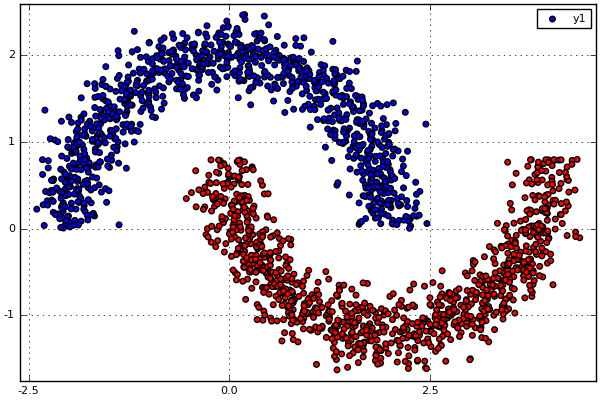

In [117]:
bendFuzz = x -> 2*(1+0.1*randn())*[cos(pi*x),sin(pi*x)]
arr1 = map(bendFuzz,rand(1000)) |> (x -> hcat(x...)');
arr2 = map( (pt -> -pt+[2.0,0.8]) ,map(bendFuzz,rand(1000))) |> (x -> hcat(x...)');
pts2 = vcat(arr1,arr2);

scatter(pts2[:,1],pts2[:,2],mc=vcat(fill(:blue,1000),fill(:red,1000)))

## For intuition

Have two clusters on the X-axis

Then, the stdev of the Gaussian corresponds to local curvature of the potential. We can build a model potential which might be captured by a fourth order (two second orders at both vacua). Can we understand the behaviour of the bifurcation (location of stable vacua and the temperature of the phase transition?). COnfirming that with field theory intuition would be great. **Ideally, plot the bifurcation structure** (clustering in a single dimension)

Imagine a distribution of points in one dimension (eg: Cantor dust). That could be modeled by a legitimate PDF i.e. potential and should give a nice bifurcation structure that is intuitively understandable!

**Does maintaining the tree structure help in classifying each point in logarithmic time instead of linear time (to compute distances and then find the minimum)?**

In [13]:
# Observe how an arbitrary ansatz code settles into the correct CVs at a given temperature

# function observeMovingCVs(beta::Float64,pts,CVinit,filename::String;n_stop::Int=6)
#     anim = Animation()
#     CV = CVinit

#     for i in collect(1:n_stop)
#         Wts = assignToCodevec(beta,pts,CV);
#         CV = reCenterCodevec(pts,Wts);
# #        scatter!(pts[:,1],pts[:,2],m=(:green,3,stroke(1,:black)))
        
#         plt = scatter(pts[:,1],pts[:,2],m=(:green,3,stroke(0,:black)),
#         leg=false,
#         xaxis=("X-label",(-5,10),[-3,0,8]),
#         yaxis=("Y-label",(-2,2)),
#         title=("Blahblah"));

#         scatter!(CV'[:,1],CV'[:,2],m=(:orange,7))
#         frame(anim)
#     end
    
#     return gif(anim,filename,fps=1,loop=1)
# end

In [14]:
#observeMovingCVs(1.5,pts2,CVinit,"foo36.gif")

LoadError: UndefVarError: observeMovingCVs not defined

In [42]:
# Initializing the codevectors and AggregWt
const Ninit = 1
CVinit = 2*randn(2,2*Ninit);
#CVinit[:,2:2:2*Ninit] = CVinit[:,1:2:2*Ninit]

AggregWtinit = ones(size(CVinit,2));

In [61]:
@time cvTracking(collect(10:1:50),pts,CVinit,AggregWtinit,"foo22.gif",0.01)

 18.307366 seconds (61.97 M allocations: 3.663 GB, 3.51% gc time)


INFO: Saved animation to /home/siva/detanneal/foo22.gif


Plots.AnimatedGif("/home/siva/detanneal/foo22.gif")


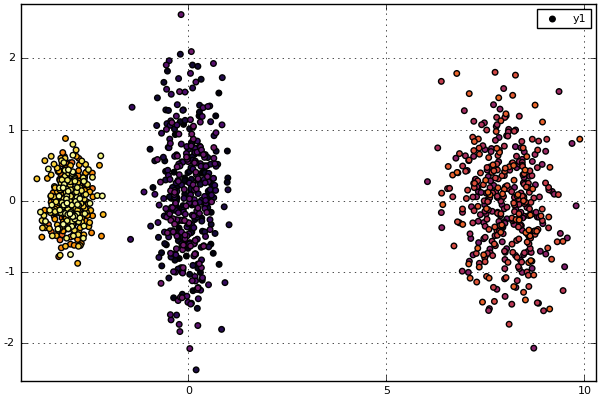

In [83]:
scatter(pts[:,1],pts[:,2],mc=(collect(1:1200)))


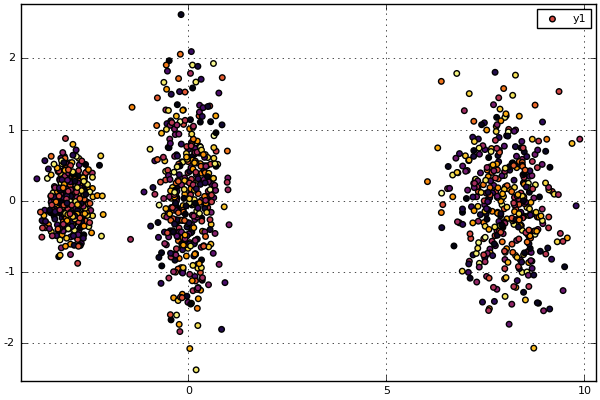

In [68]:
scatter(pts[:,1],pts[:,2],mc=(rand(400)))

In [62]:
@time cvTracking(collect(10:1:50),pts2,CVinit,AggregWtinit,"foo23.gif",0.01)

 22.040641 seconds (124.04 M allocations: 7.451 GB, 5.81% gc time)


INFO: Saved animation to /home/siva/detanneal/foo23.gif


Plots.AnimatedGif("/home/siva/detanneal/foo23.gif")

#### How to prevent the algorithm from splitting a single vacuum into sub-clusters?

Within a single "minimum" will the codevector split into multiple clusters, if/when the temperature is low enough? Is that just because there isn't enough time/iterations for that codevector to flow to the minimum? If that's the case then the finite temperature analogy does not work!? But then, maybe FT analogy only holds when the spacing between samples is much much less than the temperature (where the samples look like a continuum distribution).

1. Does this relate $\beta$ to the separation between data samples? 
    * Could it be that at that stage, the algorithm is "overfitting" to the existing samples rather than fitting to the actual underlying distribution? 
        - In such a case, will increasing the number of samples must delay the onset of such splits?
        - Another solution consists of splitting the data into training and test, and plotting the distortion -vs- rate curve on the _test data_ to see whether there is a "minimum" after which we start overfitting. But what confuses me is that in general I expect the energy (for even the test set) to decrease when we increase the nuber of clusters (if that's the case then is it really overfitting? Is it OF only because of increase in model complexity?)
        - Is this a matter of choosing an appropriate regularization?
    * In fact, what differentiates a single vacuum with smal curvature from a bunch of "smaller" vacua, as far as the algorithm is concerned? The fact that we have samples at distinct points in field space -- should that be interpreted as each of those being a kosher local minimum, rather than just "fluctuations" around a single vacuum. 
        - What is the KL divergence betwee the two distributions: single shallow Gaussian -vs- two deeper Gaussians? (Especially given N samples)


**Does the same hierarchical clustering (vector quantization) also provide the optimal Huffman encoding?**

## Phase transitions

We can *predict* the phase transitions, if we can compute the "shape" of the cluster and the largest directional variance of the Gaussian around each cluster. Once we find the axis and standard deviation, we know the temperature at which to expect the split, and the direction of $\vec{\epsilon}$ to use. If many directions have the same eigenvalues, then there will be an "explosion" of clusters corresponding to a split in each of those directions. More precisely, if $k$ directions have (approximately) equal spread, then that cluster will split into $2^k$ clusters. Of course, at the same temperature, some other cluster could also split into $2^{k^\prime}$. (So basically, those could add up to give any whole number increment of clusters during an explosion :P)

Is it hard to find the most important eigenvector (principal component) of $d$-dimensional distribution of points? Presumably one can compute the covariance matrix $C_{ij} = E[x_i x_j]$ by averaging over all pairs of points, and then use the power method (or accelerated variations thereof). If this is easy to compute, then we don't actually need to "step" in $\beta$ and can just go from PT to PT. Because, for each time-step, we have to iteraively converge to the right code-vectors, which might be a non-trivial problem.

I guess the question of which one is easier, depends on $n$ (number of points in the cluster) -vs- $d$ (dimension of the space in which the cluster lives, and could split). 

1. When $d$ is much smaller, it makes sense to try perturbations in each direction. 

2. When $n$ is smaller, is there some way to compute the principal axis easily? Maybe there is a controlled way to do this... first check the directions of the $p$-orbital lobes, then the $d$-orbital lobes, then the $f$-orbital lobes, etc? Do they add up to the $2^d$ that we expect?


For DNNs, the model has large dimensionality because the clustering regions can have complicated shapes, etc. i.e. high dimensional space of complicated functions whereas the space of data has as many dimensions as the number of pixels (for example). But's still $O({10}^{6})$

**Every time there is a bifurcation, do both the resulting clusters live in one lower dimension ambient space?** That would be akin to assuming that once we've had a split along some axis, we shouldn't expect a further split along the same axis -- i.e. we don't expect four clumps along the axis. Such a limitation seems weird. Maybe the practical statement is that after every split, we'll roughly need one bit less information for each point -- and that bit is encoded in which cluster it belongs to.

## Possible improvements:

1. Once we have clusters decide, iterate only over the elements already belinging to a cluster -- not all elements in the data set?

2. What happens if some vacua have much smaller curvatures -- leading the data samples to be more spread out (larger variance), but not in a decomposable manner? It seems like lowering the temperature might forcibly split it into two clumps even when there's no need to. But that's weird, such a potential will have a single minimum even at lower temperatures -- so maybe even if we perturb the code-vectors, they don't diverge to different centroids? I.E. a bifurcation is not encouraged?